# VGG Convolutional Neural Network Practical
*By Andrea Vedaldi and Andrew Zisserman*

This is an [Oxford Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg) computer vision practical, authored by [Andrea Vedaldi](http://www.robots.ox.ac.uk/~vedaldi/) and Andrew Zisserman (Release 2018a).

<img style="height:400px" src="data/cover.png" alt="cover"/>

*Convolutional neural networks* are an important class of learnable representation applicable, amongst others, to numerous computer vision problems. Deep CNNs, in particular, are composed of several layers of processing, each involving linear as well as non-linear operators, that are learned jointly, in an end-to-end manner, to solve a particular task. These methods are now the dominant approach for feature extraction from audiovisual and textual data.

This practical explores the basics of learning (deep) CNNs. The first part introduces typical CNN building blocks, such as ReLU units and linear filters, with a particular emphasis on understanding back-propagation. The second part looks at learning two basic CNNs. The first one is a simple non-linear filter capturing particular image structures, while the second one is a network that recognises typewritten characters (using a variety of different fonts). These examples illustrate the use of stochastic gradient descent with momentum, the definition of an objective function, the construction of mini-batches of data, and data jittering. The last part shows how powerful CNN models can be downloaded off-the-shelf and used directly in applications, bypassing the expensive training process.

$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\bp}{\mathbf{p}}
\newcommand{\cP}{\mathcal{P}}
\newcommand{\cN}{\mathcal{N}}
\newcommand{\vv}{\operatorname{vec}}
$$

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<a id='part1.1'></a>
## Part 1: CNN building blocks

### Part 1.1: convolution

A feed-forward neural network can be thought of as the composition of number of functions 
$$
f(\bx) = f_L(\dots f_2(f_1(\bx;\bw_1);\bw_2)\dots),\bw_{L}).
$$
Each function $f_l$ takes as input a datum $\bx_l$ and a parameter vector $\bw_l$ and produces as output a datum $\bx_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\bw=(\bw_1,\dots,\bw_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\bx_1,\dots,\bx_n$ are images, sounds, or more in general maps from a lattice (see [notes](#notes)) to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\bx_i$ will be a $N\times C \times U_1 \times U_2$ real array of $U_1 \times U_2$ pixels and $C$ channels per pixel representing $N$ data samples. Hence the first dimension of the array spans data samples, the second spans feature channels and the last two span space width and height, respectively. Note that only the input $\bx=\bx_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

We will use the shorthand notation $U=U_1 \times U_2$ to lump together spatial dimensions, which also allows us to neatly generalize formulas to an arbitrary number of spatial dimensions (for example, in medical imaging one may have three to represent volumetric data).

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\bx_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\bx_l$.

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{N\times C\times U} \rightarrow \mathbb{R}^{N\times K \times V},
 \qquad \bx \mapsto \by.
$$
Let us try this out now.

torch.Size([1, 3, 384, 512])
torch.Size([1, 3, 384, 512])
The image tensor shape is [1, 3, 384, 512]
The image tensor type is torch.float32


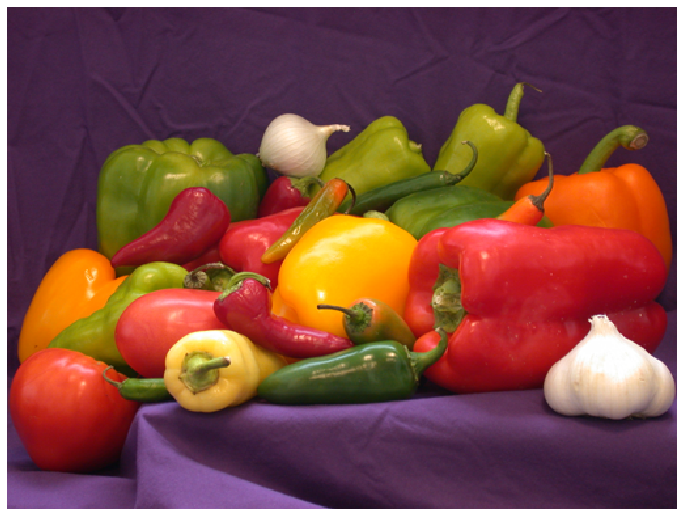

In [4]:
import lab
from matplotlib import pyplot as plt

# Read an image as a PyTorch tensor
x = lab.imread('data/peppers.png')

# Visualize the input x

plt.figure(1, figsize=(12,12))

lab.imarraysc(x)

# Show the shape of the tensor
print(f"The image tensor shape is {list(x.shape)}")

# Show the data type of the tensor
print(f"The image tensor type is {x.dtype}")

Use `x.shape` to obtain the shape of the tensor `x` and `x.dtype` to obtain its data type. Note that the tensor `x` is converted to *single precision* format. This is because the underlying PyTorch assumes that data is in single precision in most cases.

> **Question 1.** The first dimension of `x` is 3. Why?

Next, we create a bank of 10 filters, each of dimension $3\times 5 \times 5$, initialising their coefficients randomly:

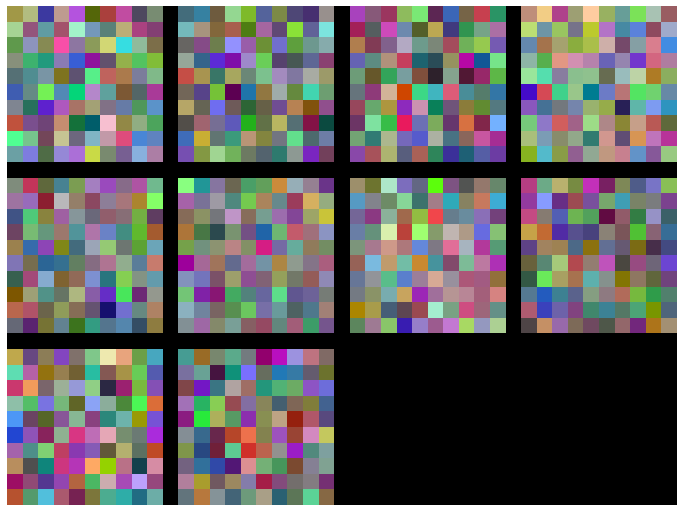

In [33]:
import torch

# Create a bank of linear filters
# w = torch.randn(10,3,5,5)
w = torch.randn(10,3,10,10)

# Visualize the filters
plt.figure(1, figsize=(12,12))
lab.imarraysc(w, spacing=1) ;

The filters are in single precision as well. Note that `w` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image. This uses the `conv2d` function from `torch.nn.functional`:

In [34]:
import torch.nn.functional as F

# Apply the convolution operator
print(x.shape)
print(w.shape)

y = F.conv2d(x, w)

# Visualize the convolution result
print(f"The output shape of y is {y.shape}")


torch.Size([1, 3, 384, 512])
torch.Size([10, 3, 10, 10])
The output shape of y is torch.Size([1, 10, 375, 503])


The variable `y` contains the output of the convolution. Note that the 10 filters are three-dimensional, packed in a four-dimensional tensor. This is because they operate on a tensor $\bx$ with $C$ channels. Furthermore, there are $K$ such filters, generating a $K$ dimensional map $\by$ as follows:

$$
y_{nkv} = \sum_{cu} w_{kcu} x_{n,c,u+v}
$$

> **Questions 2:** Study carefully this expression and answer the following:
> 
> 
>  - Given that the input map $\bx$ has $C \times U_1\times U_2$ dimensions and that each of the $K$ filters has dimension $C\times F_1 \times F_2$, what is the dimension of $\by$?
>  - Note that $x$ is indexed by $u+v$, but that there is no plus sign between $c$ and $k$. Why?

> **Task:** check that the size of the variable `y` matches your calculations.

We can now visualise the output `y` of the convolution. In order to do this, use the provided `lab.imarraysc` function to display an image for each feature channel in `y`:

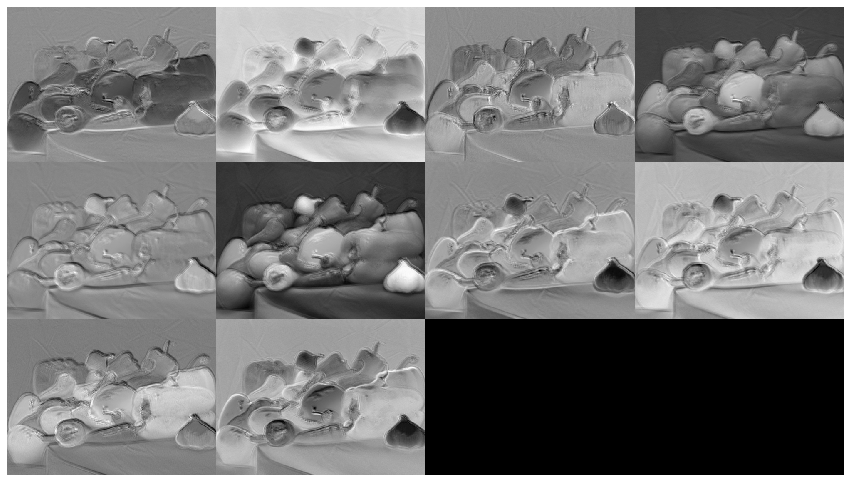

In [35]:
# Visualize the output y, one channel per image
fig = plt.figure(figsize=(15, 10))
lab.imarraysc(lab.t2im(y)) ;

> **Question 3:** Study the feature channels obtained. Most will likely contain a strong response in correspondences of edges in the input image `x`. Recall that `w` was obtained by drawing random numbers from a Gaussian distribution. Can you explain this phenomenon?

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `conv2d`:

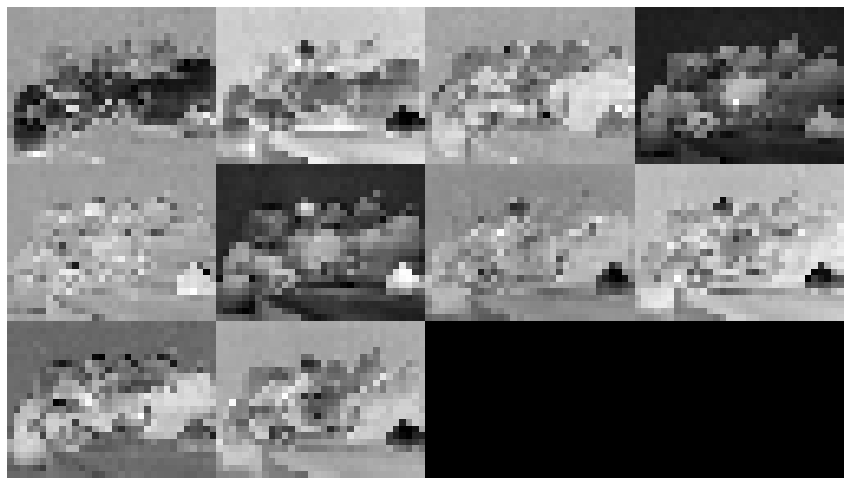

In [36]:
# Try again, downsampling the output
y_ds = F.conv2d(x, w, stride=16)

plt.figure(figsize=(15, 10))
lab.imarraysc(lab.t2im(y_ds)) ; 

As you should have noticed in a question above, applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `padding` option:

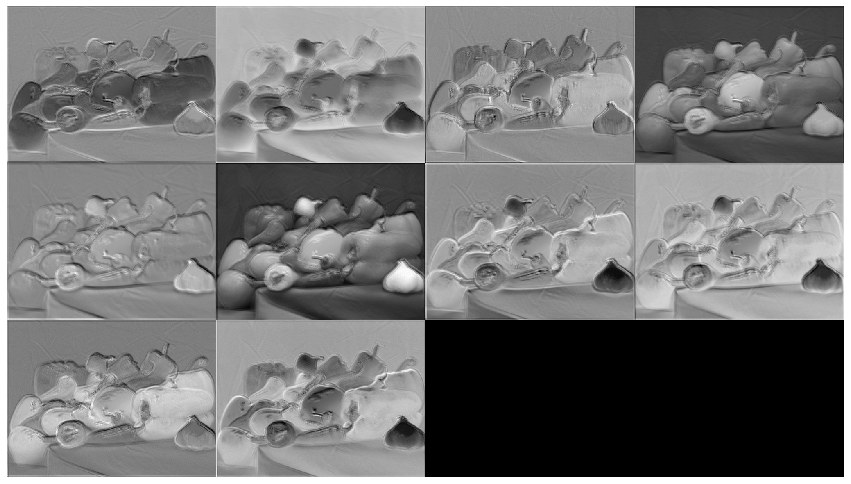

In [37]:
# Try again, downsampling the output
y_ds = F.conv2d(x, w, padding=4)

plt.figure(figsize=(15, 10))
lab.imarraysc(lab.t2im(y_ds)) ;

> **Task:** Convince yourself that the previous code's output has different boundaries compared to the code that does not use padding. Can you explain the result?

In order to consolidate what has been learned so far, we will now design a filter by hand:

The shape of the filter w is [1, 3, 3, 3]


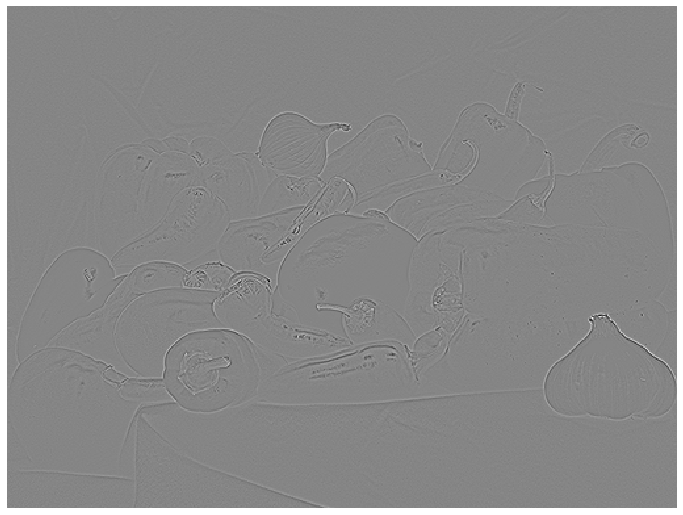

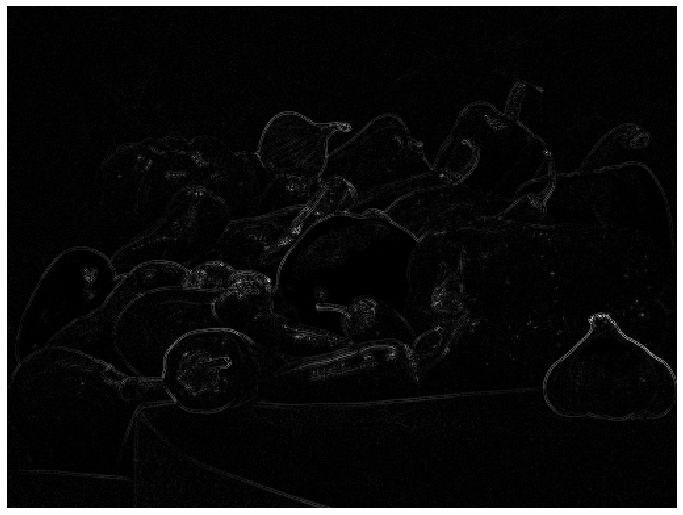

In [44]:
# Initialize a filter
w = torch.Tensor([
    [0,  1, 0 ],
    [1, -4, 1 ],
    [0,  1, 0 ]
])[None,None,:,:].expand(1,3,3,3)

print(f"The shape of the filter w is {list(w.shape)}")

# Apply convolution
y_lap = F.conv2d(x, w) ;

# Show the output
plt.figure(1,figsize=(12,12))
lab.imsc(y_lap[0])

# Show the output absolute value
plt.figure(2,figsize=(12,12))
lab.imsc(abs(y_lap)[0]) ;

> **Questions 4:**
> 
> * What filter have we implemented?
> * How are the RGB colour channels processed by this filter?
> * What image structures are detected?

### Part 1.2: non-linear activation functions

As we stated in the introduction, CNNs are obtained by composing several different functions. In addition to the linear filters shown in the [previous part](#part1.1), there are several non-linear operators as well.

> **Question 5:** Some of the functions in a CNN *must* be non-linear. Why?

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*

$$
  y_{cu} = \max\{0, x_{cu}\}.
$$

This function is implemented by `relu`; let's try this out:

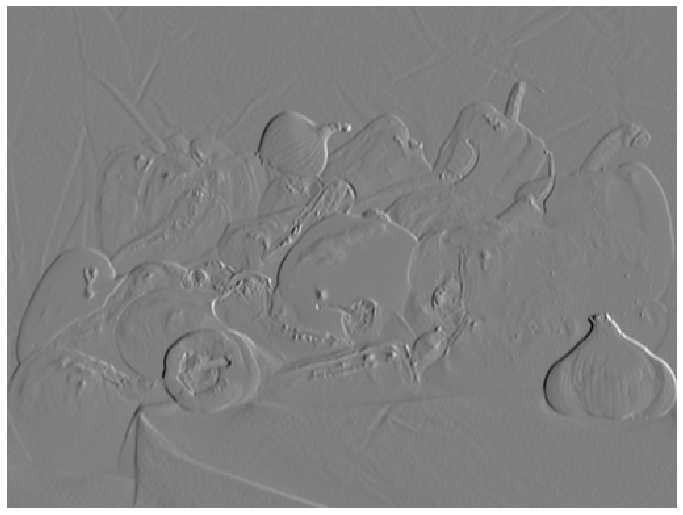

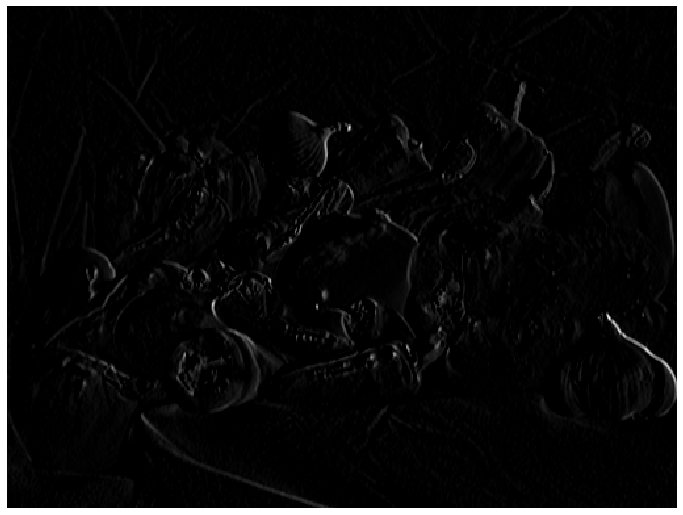

In [45]:
# Initialize a filter
w = torch.Tensor([1,  0, -1])[None,None,:].expand(1,3,3,3)

# Convolution
y = F.conv2d(x, w) ;

# ReLU
z = F.relu(y) ;

plt.figure(1,figsize=(12,12))
lab.imsc(y[0])

plt.figure(2,figsize=(12,12))
lab.imsc(z[0]) ;

> **Tasks:**
> 
> * Run the code above and understand what the filter $\bw$ is doing.
> * Explain the final result $\bz$.

### Part 1.3: pooling

There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:

$$
   y_{cv} = \max \{ x_{cu} : v \leq u < v+F \}.
$$

Max pooling is implemented by the `max_pool2d` function. Try this now:

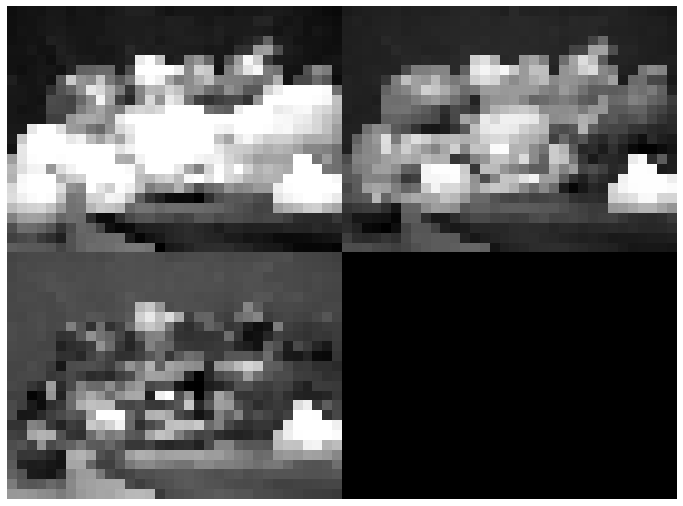

In [51]:
# y = F.max_pool2d(x, 15)
y = F.max_pool2d(x, 15)
plt.figure(1, figsize=(12,12))
lab.imarraysc(lab.t2im(y)) ;

> **Question 6:** look at the resulting image. Can you interpret the result?

The function `max_pool2d` supports subsampling and padding just like `conv2d`. However, for max-pooling feature maps are padded with the value $-\infty$ instead of 0. Why?

### Part 1.4: normalisation

Another important CNN building block is channel-wise normalisation. This operator normalises the vector of feature channels at each spatial location in the input map $\bx$. The form of the normalisation operator is actually rather curious:

$$
  y_{kv} = \frac{x_{kv}}{\left(\kappa + \frac{\alpha}{\rho} \sum_{c\in G(k)}  x_{cv}^2\right)^{\beta}}
$$

where $G(k) = \left[k - \lfloor \frac{\rho}{2} \rfloor, k + \lceil \frac{\rho}{2} \rceil\right] \cap \{0, 1, \dots, C-1\}$ is a group of $\rho$ consecutive feature channels in the input map.

> **Task:** Understand what this operator is doing. How would you set $\kappa$, $\alpha$ and $\beta$ to achieve simple $L^2$ normalisation?

Now let's try this out:

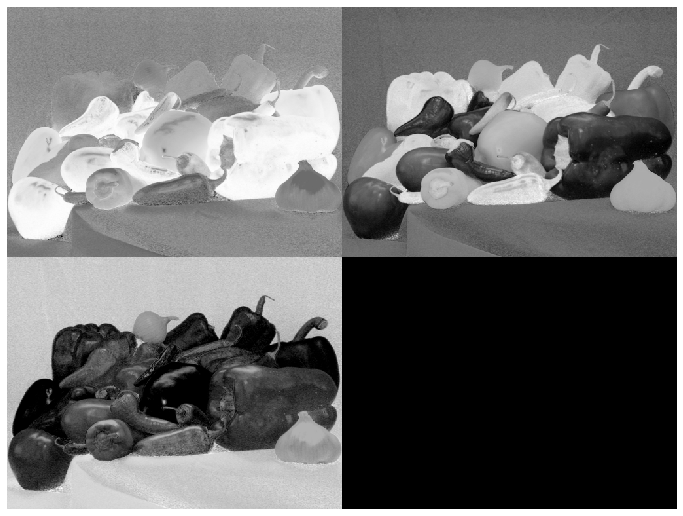

In [52]:
# LRN with some specially-chosen parameters
y_nrm = F.local_response_norm(x, 5, alpha=5, beta=0.5, k=0)

plt.figure(1,figsize=(12,12))
lab.imarraysc(lab.t2im(y_nrm)) ;

> **Tasks:** 
> 
> * Inspect the figure just obtained. Can you interpret it?
> * Compute the $L^2$ norm of the feature channels in the output map `y_nrm`. What do you notice? 
> * Explain this result in relation to the particular choice of the parameters $\rho$,  $\kappa$, $\alpha$ and $\beta$.
> * Verify your intuition by running the following code:

The difference between y_nrm and y_nrm_alt is 0.0%


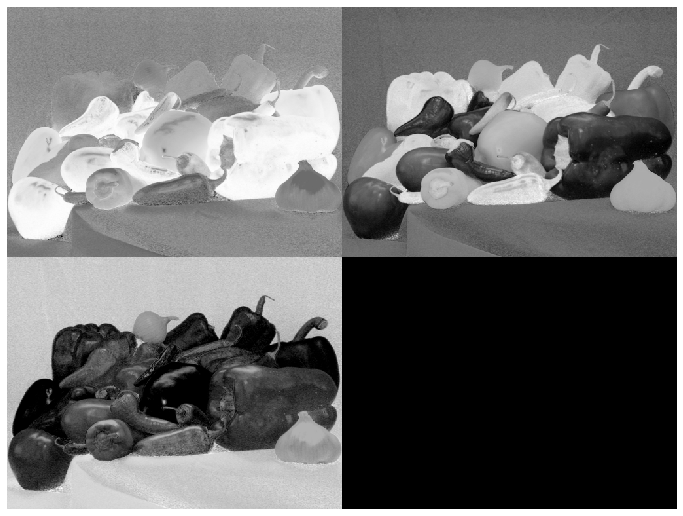

In [53]:
import math

# Another implementation of the same
y_nrm_alt = x / torch.sqrt((x**2).sum(1))

plt.figure(1,figsize=(12,12))
lab.imarraysc(lab.t2im(y_nrm_alt))

# Check that they indeed match
def compare(x,y):
    with torch.no_grad():
        a2 = torch.mean((x - y)**2)
        b2 = torch.mean(x**2)
        c2 = torch.mean(y**2)
        return 200 * math.sqrt(a2.item()) / math.sqrt(b2.item() + c2.item())

print(f"The difference between y_nrm and y_nrm_alt is {compare(y_nrm,y_nrm_alt):.1f}%")

## Part 2: back-propagation and derivatives

The parameters of a CNN $\bw=(\bw_1,\dots\bw_L)$ should be learned in such a manner that the overall CNN function  $\bz = f(\bx;\bw)$ achieves a desired goal. In some cases,  the goal is to model the distribution of the data, which leads to a *generative objective*. Here, however, we will use $f$ as a *regressor* and obtain it by minimising a *discriminative objective*. In simple terms, we are given:

* examples of the desired input-output relations $(\bx_1,\bz_1), \dots, (\bx_n,\bz_n)$ where $\bx_i$ are input data and $\bz_i$ corresponding output values;
* and a loss $\ell(\bz,\hat\bz)$ that expresses the penalty for predicting $\hat\bz$ instead of $\bz$.

We use those to write the empirical loss of the CNN $f$ by averaging over the examples:

$$
L(\bw) = \frac{1}{N} \sum_{i=1}^N \ell(\bz_i, f(\bx_i;\bw))
$$

Note that the composition of the function $f$ with the loss $\ell$ can be thought of as a CNN with one more layer (called a *loss layer*). Hence, with a slight abuse of notation, in the rest of this part we incorporate the loss in the function $f$ (which therefore is a map $\mathcal{X}\rightarrow\mathbb{R}$) and do not talk about it explicitly anymore.

The simplest algorithm to minimise $L$, and in fact one that is used in practice, is *gradient descent*. The idea is simple: compute the gradient of the objective $L$ at a current solution $\bw^t$ and then update the latter along the direction of fastest descent of $L$:

$$
 \bw^{t+1} = \bw^{t} - \eta_t \frac{\partial f}{\partial \bw}(\bw^t)
$$

where $\eta_t \in \mathbb{R}_+$ is the *learning rate*.

### Part 2.1: the theory of back-propagation

Training CNNs is normally done using a gradient-based optimization method. The CNN $f$ is the composition of $L$ layers $f_l$ each with parameters $\bw_l$, which in the simplest case of a chain looks like:

$$
 \bx_0
 \longrightarrow
 \underset{\displaystyle\underset{\displaystyle\bw_1}{\uparrow}}{\boxed{f_1}}
 \longrightarrow
 \bx_1
 \longrightarrow
 \underset{\displaystyle\underset{\displaystyle\bw_2}{\uparrow}}{\boxed{f_2}}
 \longrightarrow
 \bx_2
 \longrightarrow
 \dots
 \longrightarrow
 \bx_{L-1}
 \longrightarrow
 \underset{\displaystyle\underset{\displaystyle\bw_L}{\uparrow}}{\boxed{f_L}}
 \longrightarrow
 \bx_L
$$

During learning, the last layer of the network is the *loss function* that should be minimized. Hence, the output $\bx_L = x_L$ of the network is a **scalar** quantity (a single number).

The gradient is easily computed using using the **chain rule**. If *all* network variables and parameters are scalar, this is given by:

$$
 \frac{\partial f}{\partial w_l}(x_0;w_1,\dots,w_L)
 =
 \frac{\partial f_L}{\partial x_{L-1}}(x_{L-1};w_L) \times
 \cdots
 \times
 \frac{\partial f_{l+1}}{\partial x_l}(x_l;w_{l+1}) \times
 \frac{\partial f_{l}}{\partial w_l}(x_{l-1};w_l)
$$

With tensors, however, there are some complications. Consider for instance the derivative of a function $\by=f(\bx)$ where both $\by$ and $\bx$ are tensors; this is formed by taking the derivative of each scalar element in the output $\by$ with respect to each scalar element in the input $\bx$. If $\bx$ has dimensions $C \times U_1 \times U_2$ and $\by$ has dimensions $K \times V_1 \times V_2$, then the derivative contains $C\cdot U_1\cdot U_2\cdot K\cdot V_1\cdot V_2$ elements, which is often unmanageable (in the order of several GBs of memory for a single derivative).

Note that all intermediate derivatives in the chain rule may be affected by this size explosion except for the derivative of the network output that, being the loss, is a scalar.

> **Question 7:** The output derivatives have the same size as the parameters in the network. Why?

**Back-propagation** allows the output derivatives to be computed in a memory-efficient manner. To see how, the first step is to generalize the equation above to tensors using a matrix notation. This is done by converting tensors into vectors by using the $\vv$ (stacking; see the [notes](#notes)) operator:

$$
 \frac{\partial \vv f}{\partial \vv \bw_l}
 =
 \frac{\partial \vv f_L}{\partial \vv \bx_L} \times
 \cdots
 \times
 \frac{\partial \vv f_{l+1}}{\partial \vv \bx_l} \times
 \frac{\partial \vv f_{l}}{\partial \vv \bw_l}
$$

In order to make this computation memory efficient, we *project* the derivative with respect to a tensor $\bp_L = 1$ as follows:

$$
 (\vv \bp_L) \times \frac{\partial \vv f}{\partial \vv \bw_l}
 =
 (\vv \bp_L)
 \times
 \frac{\partial \vv f_L}{\partial \vv \bx_L} \times
 \cdots
 \times
 \frac{\partial \vv f_{l+1}}{\partial \vv \bx_l} \times
 \frac{\partial \vv f_{l}}{\partial \vv \bw_l}
$$

Note that $\bp_L=1$ has the same dimension as $\bx_L$ (the scalar loss) and, being equal to 1, multiplying it to the left of the expression does not change anything. Things are more interesting when products are evaluated from the left to the right, i.e. *backward from the output to the input* of the CNN. The first such factor is given by:

$$
\begin{equation}
\label{e:factor}
 (\vv \bp_{L-1}) = (\vv \bp_L)
 \times
 \frac{\partial \vv f_L}{\partial \vv \bx_L}
\end{equation}
$$

This results in a new projection vector $\bp_{L-1}$, which can then be multiplied from the left to obtain $\bp_{L-2}$ and so on. The last projection $\bp_l$ is the desired derivative. Crucially, each projection $\bp_q$ takes as much memory as the corresponding variable $\bx_q$.

Some might have noticed that, while projections remain small, each factor (\ref{e:factor}) does contain one of the large derivatives that we cannot compute explicitly. The trick is that CNN toolboxes contain code that can compute the projected derivatives without explicitly computing this large factor. In particular, for any building block function $\by=f(\bx;\bw)$, a toolbox will implement:

* A **forward mode** computing the function $\by=f(\bx;\bw)$.
* A **backward mode** computing the derivatives of the projected function $\langle \bp, f(\bx;\bw) \rangle$ with respect to the input $\bx$ and parameter $\bw$:

$$
\frac{\partial}{\partial \bx} \left\langle \bp, f(\bx;\bw) \right\rangle,
\qquad
\frac{\partial}{\partial \bw} \left\langle \bp, f(\bx;\bw) \right\rangle.
$$

For example, this is how this looks for the convolution operator:

In [54]:
y = F.conv2d(x,w) # forward mode (get output y)
p = torch.randn(y.shape) # get a random tensor with the same size as y

# Directly call backward functions for demonstration
dx = torch.nn.grad.conv2d_input(x.shape, w, p)
dw = torch.nn.grad.conv2d_weight(x, w.shape, p)

print(f"The shape of x is {list(x.shape)} and that of dx is {list(dx.shape)}")
print(f"The shape of w is {list(x.shape)} and that of dw is {list(dx.shape)}")
print(f"The shape of y is {list(y.shape)} and that of  p is {list(p.shape)}")

The shape of x is [1, 3, 384, 512] and that of dx is [1, 3, 384, 512]
The shape of w is [1, 3, 384, 512] and that of dw is [1, 3, 384, 512]
The shape of y is [1, 1, 382, 510] and that of  p is [1, 1, 382, 510]


PyTorch transparently implements AutoDiff, which means that you rarely have to invoke the backward functions *explicitly*. In fact, in most cases they are *not* available. Instead, you invoke the `backward()` method on an output tensor in order to compute the gradients. Let us try this now:

In [55]:
x.requires_grad_(True)
w.requires_grad_(True)
if x.grad is not None:
    x.grad.zero_()
if w.grad is not None:
    w.grad.zero_()
y = F.conv2d(x,w) 
y.backward(p)
dx_ = x.grad
dw_ = w.grad

print(f"The difference between dx and dx_ is {compare(dx,dx_):.1f}%")
print(f"The difference between dw and dw_ is {compare(dw,dw_):.1f}%")

The difference between dx and dx_ is 0.0%
The difference between dw and dw_ is 0.0%


While this looks very verbose, in practice it saves a lot of time with complex networks. Furthermore, note that:

1. Variables for which gradients are required must be marked with `requires_grad_()`. This is so that PyTorch knows which gradients to compute.
2. Each variable `x` has a field `x.grad` storing its gradient. Before gradients are computed, it must be cleared (set to zero). The reason is that gradient calculations are *accumulated*.
3. Gradients are computed automatically by invoking `y.backward(p)` on the output tensor. The parameter `p` can be omitted if the output is a scalar, in which case it defaults to 1.

### Part 2.1: using back-propagation in practice

To see how backpropagation is used in practice, focus on a computational block $f$, followed by a function $g$:

$$
 \bx
 \longrightarrow 
 \underset{\displaystyle\underset{\displaystyle\bw}{\uparrow}}{\boxed{f}} 
 \longrightarrow
 \by
 \longrightarrow 
 \boxed{g}
 \longrightarrow
 z
$$

Here $g$ lumps the rest of the network, from $\by$ to the final scalar output $z$. The goal is to compute the derivatives $\partial z / \partial \bx$ and $\partial z / \partial \bw$ given the derivative $\bp = \partial z / \partial \by$ of the rest of the network $g$.

Let's put this into practice by letting $f$ be a convolutional layer and by filling $\bp = \partial z / \partial \by$ with random values for the sake of the example:

In [56]:
# Read an example image
x = lab.imread('data/peppers.png')
x.requires_grad_(True)

# Create a bank of linear filters
w = torch.randn(10,3,5,5)
w.requires_grad_(True)

# Forward
y = F.conv2d(x, w)

# Set the derivative dz/dy to a randmo value
dzdy = torch.randn(y.shape)

# Backward
y.backward(dzdy)
dzdx = x.grad
dzdw = w.grad

print(f"Size of dzdx = {list(dzdx.shape)}")
print(f"Size of dzdw = {list(dzdw.shape)}")

Size of dzdx = [1, 3, 384, 512]
Size of dzdw = [10, 3, 5, 5]


> **Task:** Run the code above and check the dimensions of `dzdx` and `dzdy`. Does this match your expectations?

An advantage of this modular view is that new building blocks can be coded and added to the architecture in a simple manner. However, it is easy to make mistakes in the calculation of complex derivatives. Hence, it is a good idea to verify results numerically. Consider the following piece of code:

In [60]:
# Check the derivative numerically
with torch.no_grad():
    delta = torch.randn(x.shape)
    step = 0.0001
    xp = x + step * delta
    yp = F.conv2d(xp, w)
    dzdx_numerical = torch.sum(dzdy * (yp - y) / step)
    dzdx_analytical = torch.sum(dzdx * delta)
    err = compare(dzdx_numerical,dzdx_analytical)

print(f"dzdx_numerical: {dzdx_numerical}")
print(f"dzdx_analytical: {dzdx_analytical}")
print(f"numerical vs analytical rel. error: {err:.3f}%")
print(f"nmemerr: {(dzdx * delta).shape}")


dzdx_numerical: -11215.9267578125
dzdx_analytical: -11221.048828125
numerical vs analytical rel. error: 0.065%
nmemerr: torch.Size([1, 3, 384, 512])


> **Questions 8:**
> 
> * What is the meaning of `delta` in the code above? 
> * What are the derivatives `dzdx_numerical` and `dzdx_analytical`?
>
> **Tasks:**
> 
> *  Run the code and convince yourself that `conv2d` derivatives is (probably) correct.
> * Create a new version of this code to test the derivative calculation with respect to $\bw$.

We are now ready to build our first elementary CNN, composed of just two layers, and to compute its derivatives:

In [61]:
# Read an example image
x1 = lab.imread('data/peppers.png')
x1.requires_grad_(True)

# Create a bank of linear filters
w1 = torch.randn(10,3,5,5)
w1.requires_grad_(True)

# Other CNN parameters
pool2_size = 10

# Run the CNN forward
x2 = F.conv2d(x1, w1)
x3 = F.max_pool2d(x2, pool2_size)

# Create the derivative dz/dx3
dzdx3 = torch.randn(x3.shape)

# Run the CNN backward
x3.backward(dzdx3)
dzdx1 = x1.grad
dzdw1 = w1.grad

print(f"Size of dzdx1 = {list(dzdx1.shape)}")
print(f"Size of dxdw1 = {list(dzdw1.shape)}")

Size of dzdx1 = [1, 3, 384, 512]
Size of dxdw1 = [10, 3, 5, 5]


> **Question 9:** Note that the last derivative in the CNN is `dzdx3`. Here, for the sake of the example, this derivative is initialised randomly. In a practical application, what would this derivative represent?

We can now use the same technique as before to check that the derivatives computed through back-propagation are correct.

In [ ]:
# Check the derivative numerically
with torch.no_grad():
    delta = torch.randn(w1.shape)
    step = 0.00001
    w1p = w1 + step * delta
    x1p = x1
    x2p = F.conv2d(x1p, w1p)
    x3p = F.max_pool2d(x2p, pool2_size)
    
    dzdw1_numerical = torch.sum(dzdx3 * (x3p - x3) / step)
    dzdw1_analytical = torch.sum(dzdw1 * delta)
    err = compare(dzdw1_numerical, dzdw1_analytical)

print(f"dzdw1_numerical: {dzdw1_numerical}")
print(f"dzdw1_analytical: {dzdw1_analytical}")
print(f"numerical vs analytical rel. error: {err:.3f}%")

## Part 3: learning a tiny CNN

In this part we will learn a very simple CNN. The CNN is composed of exactly two layers: a convolutional layer and an average-pooling layer:

$$
\bx_2 = W * \bx_1 + b, \qquad \bx_3 = \operatorname{avgpool}_\rho \bx_2.
$$

$W$ contains a single $3\times 3$ square filter, so that $b$ is a scalar, and the input image $\bx=\bx_1$ has a single channel.

In [62]:
def tinycnn(x, w, b):
    pad1 = (w.shape[2] - 1) // 2
    rho2 = 3
    pad2 = (rho2 - 1) // 2
    x = F.conv2d(x, w, b, padding=pad1)
    x = F.avg_pool2d(x, rho2, padding=pad2, stride=1)
    return x

> **Task**
> 
> * Inspect the code and convince yourself that the code computes the CNN just described.
> * Look at the paddings used in the code. If the input image $\bx_1$ has dimensions $M\times N$, what is the dimension of the output feature map $\bx_3$?
> 

In the rest of the section we will learn the CNN parameters in order to extract blob-like structures from images, such as the ones in the following image:

<img width=350px src="data/dots.jpg" alt="dotted-shirt"/>

### Part 3.1: training data and labels

The first step is to load the image `data/dots.jpg` and to use the supplied `extractBlackBlobs` function to extract all the black dots in the image.

In [68]:
# Load a training image and convert to gray-scale
im0 = lab.imread('data/dots.jpg')
im0 = im0.mean(dim=1)[None,:,:,:]

# Compute the location of black blobs in the image
pos, neg, indices = lab.extract_black_blobs(im0)
pos = pos / pos.sum()
neg = neg / neg.sum()


The arrays `pos` and `neg` contain now pixel labels and  will be used as *annotations* for the supervised training of the CNN. These annotations can be visualised as follows:

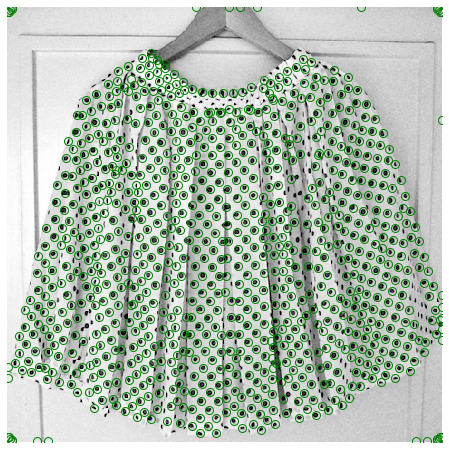

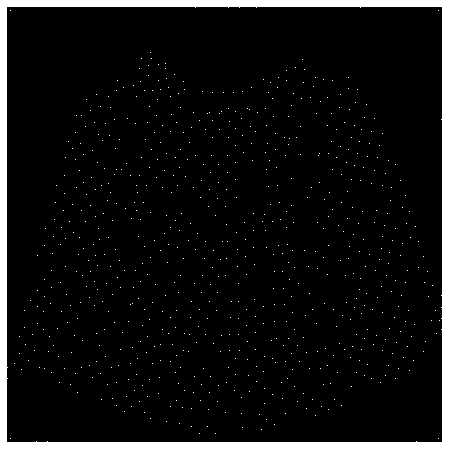

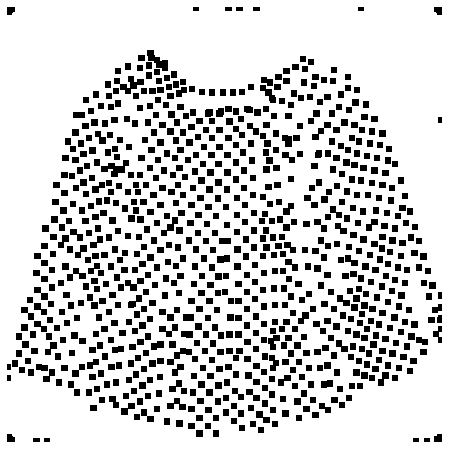

In [64]:
# Display the training data
plt.figure(1, figsize=(8,8))
lab.imsc(im0[0])
plt.plot(indices[1], indices[0],'go', markersize=8, mfc='none')

plt.figure(2, figsize=(8,8))
lab.imsc(pos[0])

plt.figure(3, figsize=(8,8))
lab.imsc(neg[0]) ;

> **Task:** Inspect `pos` and `neg` and convince yourself that:
>
> - `pos` contains a single `true` value in correspondence of each blob centre;
> - `neg` contains a `true` value for each pixel sufficiently far away from a blob.
> 
> Are there pixels for which both `pos` and `neg` evaluate to false?

### Part 3.2: image preprocessing

Before we attempt to train the CNN, the image is pre-processed to remove its mean value. It is also smoothed by applying a Gaussian kernel of standard deviation 3 pixels:

In [69]:
# Preprocess the image by subtracting its mean
im = im0 - im0.mean()
im = lab.imsmooth(im, 3)

We will come back to these preprocessing steps later.

### Part 3.3: learning with gradient descent

We will now setup a learning problem to learn $W$ and $b$ to detect black blobs in images. Recall that the CNN computes for each image pixel $(u,v)$ a score $f(\bx;\bw,b)_{(u,v)}$. We would like this score to be:

* at least as large as 1 for any pixel that is marked as a blob centre (`pos` or $(u,v)\in\cP$) and
* at most zero for any pixel that is marked as being far away from a blob (`neg` or $(u,v)\in\cN$).

We do so by defining and then optimising the following objective function:
$$
E(\bw,b) = 
\frac{\lambda}{2}\|\bw\|^2
+
\frac{1}{|\cP|}\sum_{(u,v) \in \cP}
\max\{0, 1 - f(\bx;\bw,b)_{(u,v)}\}
+
\frac{1}{|\cN|}\sum_{(u,v) \in \cN}
\max\{0, f(\bx;\bw,b)_{(u,v)}\}.
$$

> **Questions 10:**
> 
> - What can you say about the score of each pixel if $\lambda=0$ and $E(\bw,b) =0$?
> - Note that the objective enforces a *margin* between the scores of the positive and negative pixels. How much is this margin?

We can now train the CNN by minimising the objective function with respect to $\bw$ and $b$. We do so by using an algorithm called *gradient descent with momentum*.  Given the current solution $(\bw_t,b_t)$, this is updated to $(\bw_{t+1},b_{t+1})$ by following the direction of fastest descent of the objective $E(\bw_t,b_t)$ as given by the negative gradient $-\nabla E$. However, gradient updates are smoothed by considering a *momentum* term $\mu_{t}$, yielding the update equations
$$
 \mu_{t+1} \leftarrow m \mu_t + (1-m)\frac{\partial E}{\partial \bw_t},
 \qquad
 \bw_{t+1} \leftarrow \bw_{t} - \eta \mu_{t+1}
$$
and similarly for the bias term. Here $m$ is the *momentum rate* and $\eta$ the *learning rate*.

> **Questions 11:**
>
> - Explain why the momentum rate must be smaller than 1. What is the effect of having a momentum rate close to 1?
> - The learning rate establishes how fast the algorithm will try to minimise the objective function. Can you see any problem with a large learning rate?

The algorithm is implemented as follows:

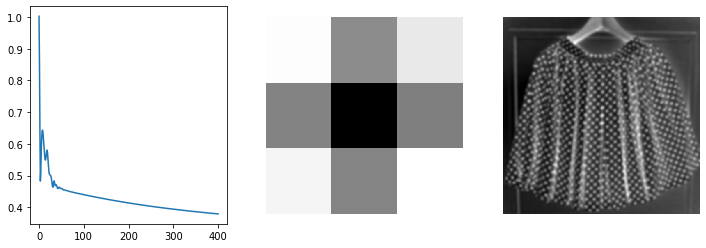

In [70]:
num_iterations = 501
rate = 10
momentum = 0.9
shrinkage = 0.0001
plot_period = 200

with torch.no_grad():
    w = torch.randn(1,1,3,3)
    w = w - w.mean()
    b = torch.Tensor(1)
    b.zero_()

E = []
w.requires_grad_(True)
b.requires_grad_(True)
w_momentum = torch.zeros(w.shape)
b_momentum = torch.zeros(b.shape)

for t in range(num_iterations):

    # Evaluate the CNN and the loss
    y = tinycnn(im, w, b)
    z = (pos * (1 - y).relu() + neg * y.relu()).sum()

    # Track energy
    E.append(z.item() + 0.5 * shrinkage * (w**2).sum().item())

    # Backpropagation
    z.backward()

    # Gradient descent
    with torch.no_grad():
        w_momentum = momentum * w_momentum + (1 - momentum) * (w.grad + shrinkage * w)
        b_momentum = momentum * b_momentum + (1 - momentum) * b.grad
        w -= rate * w_momentum
        b -= 0.1 * rate * b_momentum        
        w.grad.zero_()
        b.grad.zero_()

    # Plotting
    if t % plot_period == 0:
        plt.figure(1,figsize=(12,4))
        plt.clf()
        fig = plt.gcf()
        ax1 = fig.add_subplot(1, 3, 1)
        plt.plot(E)
        ax2 = fig.add_subplot(1, 3, 2)
        lab.imsc(w.detach()[0])
        ax3 = fig.add_subplot(1, 3, 3)
        lab.imsc(y.detach()[0])

> **Tasks:**
> 
> - Convince yourself that the code above is implementing the algorithm as described. Pay particular attention to the forward and backward passes as well as at how the objective function and its derivatives are computed.
> - Run the algorithm and observe the results. Then answer the following questions:
>     * The learned filter should resemble the discretisation of a well-known differential operator. Which one? 
>     * What is the average of the filter values compared to the average of the absolute values?

### Part 3.4: experimenting with the tiny CNN

In this part we will experiment with several variants of the network just learned. First, we study the effect of the image smoothing:

> **Task:** Train again the tiny CNN *without smoothing the input image in preprocessing*. Answer the following questions:
> 
>   * Is the learned filter very different from the one learned before?
>   * If so, can you figure out what "went wrong"?
>   * Look carefully at the output of the first layer, magnifying with the loupe tool. Is the maximal filter response attained in the middle of each blob?
>
> **Hint:** The Laplacian of Gaussian operator responds maximally at the centre of a blob only if the latter matches the blob size. Relate this fact to the combination of pre-smoothing the image and applying the learned $3\times 3$ filter.

Now restore the smoothing but adding instead of subtracting the median from the input image.

> **Task:** Train again the tiny CNN *by adding instead of subtracting the median value in preprocessing*. Answer the following questions:
>
>   * Does the algorithm converge?
>   * Reduce a hundred-fold the learning rate and increase the maximum number of iterations by an equal amount. Does it get better?
>   * Explain why adding a constant to the input image can have such a dramatic effect on the performance of the optimisation.
>
> **Hint:** What constraint should the filter $\bw$ satisfy if the filter output should be zero when (i) the input image is zero or (ii) the input image is a large constant? Do you think that it would be easy for gradient descent to enforce (ii) at all times?

What you have just witnessed is actually a fairly general principle: centring the data usually makes learning problems much better conditioned.

Now we will explore several parameters in the algorithms:

> **Task:** Restore the preprocessing as given originally.  Try the following:
>
> * Try increasing the learning rate `rate`. Can you achieve a better value of the energy in the 501 iterations?
> * Disable momentum by setting `momentum = 0`. Now try to beat the result obtained above by choosing `rate`. Can you succeed?

Finally, consider the regularisation effect of shrinking:

> **Task:** Restore the learning rate and momentum as given originally. Then increase the shrinkage factor tenfold and a hundred-fold.
> 
> - What is the effect on the convergence speed?
> - What is the effect on the final value of the total objective function and of the average loss part of it?

## Part 4: learning a character CNN

In this part we will learn a CNN to recognise images of characters.  

### Part 4.1: prepare the data

The code loads a structure `imdb` containing images of the characters *a, b, ..., z* rendered using 29,094 fonts downloaded from the [Google Fonts Project](https://www.google.com/fonts). The structure is a dictionary with various subfields:

In [71]:
# Load data
imdb = torch.load('data/charsdb.pth')
print(f"imdb['images'] has shape {list(imdb['images'].shape)}")
print(f"imdb['labels'] has shape {list(imdb['labels'].shape)}")
print(f"imdb['sets'] has shape {list(imdb['sets'].shape)}")

imdb['images'] has shape [29094, 1, 32, 32]
imdb['labels'] has shape [29094]
imdb['sets'] has shape [29094]


`imdb['images']` contains a $32 \times 32$ image for each character, stored as 5D tensor with $29,094 = 1,119\cdot 26$ images, each of which has dimensions $1\times 32\times 32$. `imdb['labels']` is a corresponding tensor of image labels, denoting which one of the 26 possible characters it is. `imdb['sets']` is equal to 0 for each image that should be used to train the CNN and to 1 for each image that should be used for validation.

We can visualize some of the images for the character `a` as follows:

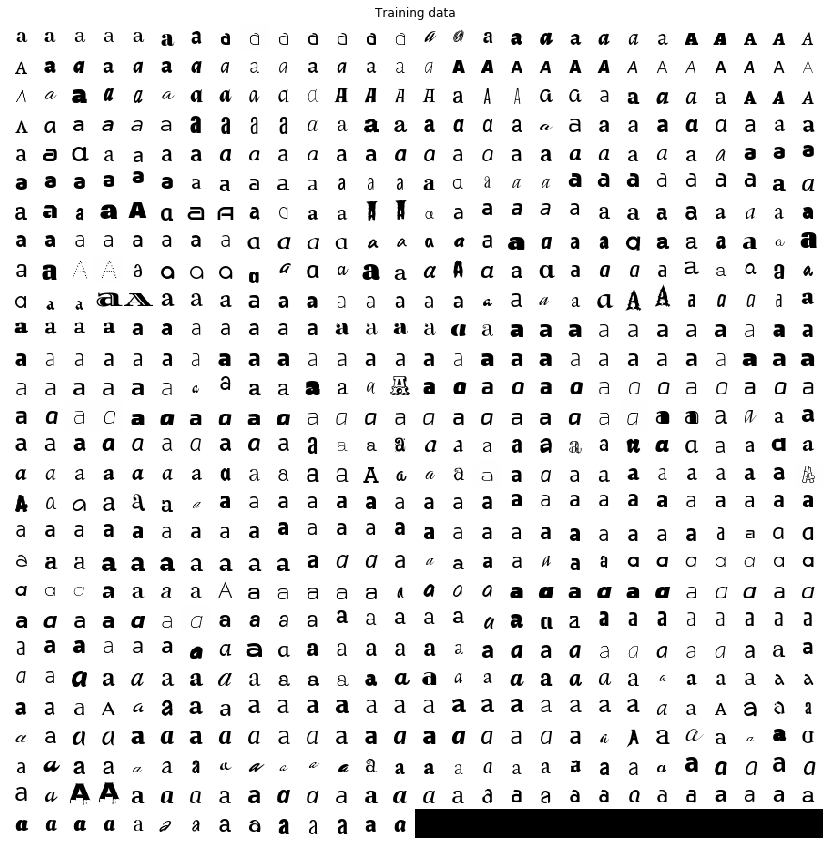

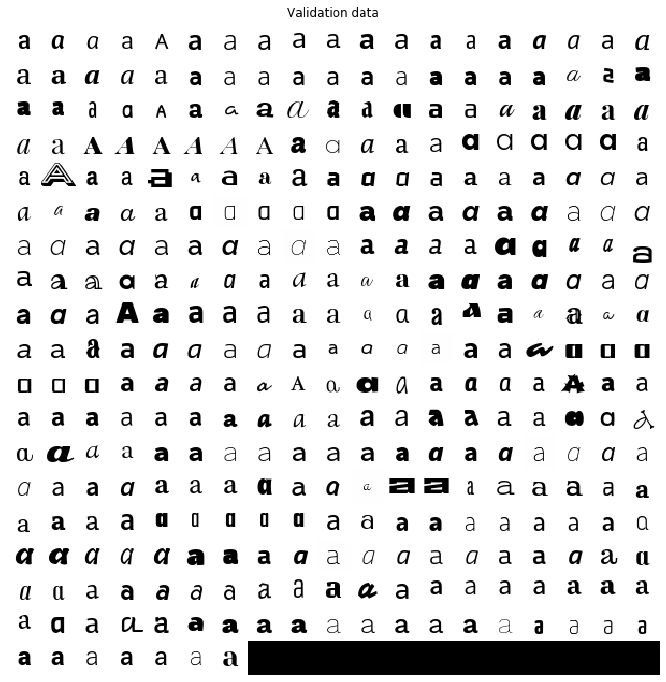

In [72]:
# Plot the training data for 'a'
plt.figure(1,figsize=(15,15))
plt.clf()
plt.title('Training data')
sel = (imdb['sets'] == 0) & (imdb['labels'] == 0)
lab.imarraysc(imdb['images'][sel,:,:,:])

# Plot the validation data for 'a'
plt.figure(2,figsize=(12,12))
plt.clf()
plt.title('Validation data')
sel = (imdb['sets'] == 1) & (imdb['labels'] == 0)
lab.imarraysc(imdb['images'][sel,:,:,:]) ;

> **Task:** look at the figure above generated by the code and at the code itself and make sure that you understand what you are looking at.

### Part 4.2: initialize a CNN architecture

So far, we have used the so-called "functional" interface to PyTorch. The framework, however, also offers modules that wrap the functional interface in convenience classes for building deep neural networks. We will now use such classes to initialize a network to recognize characters:

In [73]:
import torch.nn as nn

def new_model():
    return nn.Sequential(
        nn.Conv2d(1,20,5),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(20,50,5),
        nn.MaxPool2d(2,stride=2),
        nn.Conv2d(50,500,4),
        nn.ReLU(),
        nn.Conv2d(500,26,2),
    )

model = new_model()

> **Task:** By inspecting the code above, get a sense of the architecture that will be trained. How many layers are there? How big are the filters?

The network defines a sequence of layers. The convolutional layers implicitly contain parameter tensors (the filter weights and biases), pre-initialized using random numbers. This means that, albeit the output will be random, we can already apply the network to a character, as follows:

In [74]:
# Evaluate the network on three images
y = model(imdb['images'].narrow(0,0,3))
print(f"The size of the network output is {list(y.shape)}")

The size of the network output is [3, 26, 1, 1]


Note that the *penultimate* layer has dimensions $3 \times 26 \times 1 \times 1$; this is because there are $N=3$ images in this batch, $C=26$ predicted scores, one for each possible character, and the spatial resolution is $1\times 1$, as the network makes a global decision for the whole character image. This type of network is sometimes called "fully convolutional" as it only uses convolution-like operators; an advantage is that the network can be applied to arbitrarly-wide images, which we will use later to recognise a character string. However, the last two dimensions are here a nuisance, so we get rid of them.

In [75]:
# Preserves only the first two dimensions
y = y.reshape(*y.shape[:2])
print(f"The size of the network output is now {list(y.shape)}")

The size of the network output is now [3, 26]


In order to train the network, we use the cross-entropy loss, implemented by the `nn.CrossEntropyLoss()` layer.
This combines the *softmax* operator to turn character scores in probabilities:

$$
  y_{nk} = \frac{e^{x_{nk}}}{\sum_{c=0}^{C-1} e^{x_{nc}}}
$$

followed by the *log-loss* to compare such probabilities to the ground-truth characters `c`:

$$
  z = - \frac{1}{N} \sum_{n=0}^{N-1} \log y_{n c_{n}}
$$

where $0 \leq c_{n} < C$ is the ground-truth character class for the $n$-th example.

> **Tasks:**
>
> 1.  Understand what the softmax operator does. **Hint:** to use the log-loss the data must be in the (0, 1] interval.
> 2.  Understand what is the effect of minimising the log-loss. Which neural response should become larger?
> 3.  Why do you think PyTorch provides `nn.CrossEntropyLoss()` combining both functions into a single layer?

Just like any other PyTorch module, module instances are callable as if they were functions. The following code demonstrate this:

In [76]:
# Evaluate the cross-entropy loss on the network output assuming that 'a', 'b', 'c' are the ground-truth chars
loss = nn.CrossEntropyLoss()
c = torch.LongTensor([ord('a'), ord('b'), ord('c')]) - ord('a')
z = loss(y, c)

print(f"The loss value is {z.item():.3f}")

The loss value is 3.207


### Part 4.3: train and evaluate the CNN

We are now ready to train the CNN. To this end we will use the `lab.train_model()` function provided with the practical code. This function is defined in the provided `lab` Python module, which can be [opened in the editor](../../edit/practical-cnn-pytorch-2018a/lab.py). The function is defined as follows:

```python
def train_model(model, imdb, batch_size=100, num_epochs=15, use_gpu=False, use_jitter=False)
```



By default, the training will use a mini-batch size of 100 elements, run for 15 epochs (passes through the data), not use the GPU and it will use a learning rate of 0.001.

Before the training starts, the average image value is subtracted as before. We keep around `im_mean` for later use.

In [77]:
# Remove average intensity from input images
im_mean = imdb['images'].mean()
imdb['images'].sub_(im_mean) ;

This is similar to what we have done in Part 3.

The training code is called as follows (and we will run it first for just two epochs):

beginning epoch 0 of 2
epoch: 01/02 train iter: 001/201 speed: 875.4 Hz loss: 3.26 acc: 3.0%
epoch: 01/02 train iter: 051/201 speed: 964.2 Hz loss: 3.07 acc: 14.1%
epoch: 01/02 train iter: 101/201 speed: 921.0 Hz loss: 2.39 acc: 32.6%
epoch: 01/02 train iter: 151/201 speed: 904.8 Hz loss: 1.90 acc: 46.9%
epoch: 01/02 train iter: 201/201 speed: 893.9 Hz loss: 1.60 acc: 55.3%
epoch: 01/02 val iter: 001/091 speed: 892.5 Hz loss: 0.20 acc: 97.0%
epoch: 01/02 val iter: 051/091 speed: 848.7 Hz loss: 0.74 acc: 80.8%


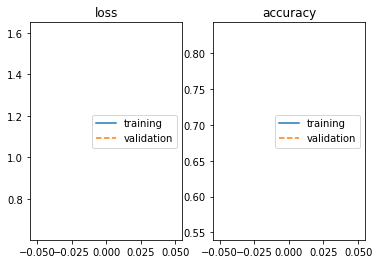

beginning epoch 1 of 2
epoch: 02/02 train iter: 001/201 speed: 794.4 Hz loss: 0.98 acc: 72.0%
epoch: 02/02 train iter: 051/201 speed: 876.8 Hz loss: 0.60 acc: 83.9%
epoch: 02/02 train iter: 101/201 speed: 873.8 Hz loss: 0.53 acc: 85.9%
epoch: 02/02 train iter: 151/201 speed: 878.2 Hz loss: 0.51 acc: 86.4%
epoch: 02/02 train iter: 201/201 speed: 874.8 Hz loss: 0.47 acc: 87.3%
epoch: 02/02 val iter: 001/091 speed: 873.6 Hz loss: 0.06 acc: 98.0%
epoch: 02/02 val iter: 051/091 speed: 831.8 Hz loss: 0.48 acc: 88.0%


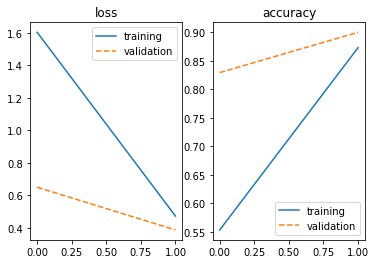

In [78]:
# Initialize the model
model = new_model()

# Run SGD to train the model
model = lab.train_model(model, imdb, num_epochs=2, use_gpu=False)

**Is the training taking too long?** If you have access to a GPU you could go to the next part to train the model for the full 15 epochs. Otherwise, you need to restart the CPU training set for 15 epochs, and wait until the training finishes.

> **Task:** Run the learning code and examine the plots that are produced. As training completes answer the following questions:
>
> 1.  How many images per second can you process? (Look at the rate of output on the screen)
> 2.  There are two sets of curves: energy and prediction error. What do you think is the difference? What is the "loss" and the "accuracy"?
> 3.  Some curves are labelled "training" and some other "validation".  Should they be equal? Which one should be lower than the other?

Once training is finished, the `model` object contains the trained parameters.


### Part 4.4: Training using the GPU

> Skip this part if you do not wish to experiment training using GPU hardware.

A key challenge in deep learning is the sheer amount of computation required to train gigantic models from equally gigantic data collections. State-of-the-art vision models, for example, take weeks to train on specialised hardware such as GPUs, and they are essentially untrainable on CPU (unless you have access to a very large cluster). Thus it is practically important to learn how to use this hardware.

Frameworks such as PyTorch make it almost trivial to run computations on a GPU

> **Task:** Train the models for 15 epochs using `use_gpu=True` and note the speed of training. How many images per second can you process now?

For these small images, the GPU speedup is probably modest (perhaps 5 fold). However, for larger models it becomes really dramatic (>10 fold).

### Part 4.5: visualise the learned filters

The next step is to glance at the filters that have been learned:

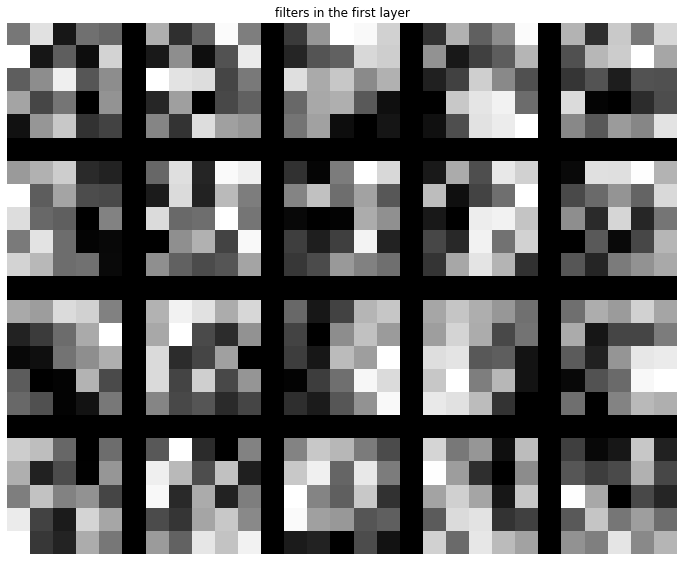

In [79]:
# Visualize the filters in the first layer
plt.figure(1, figsize=(12,12))
plt.title('filters in the first layer')
lab.imarraysc(model[0].weight, spacing=1) ;

> **Task:** what can you say about the filters?

### Part 4.6: apply the model

We now apply the model to a whole sequence of characters. This is the image `data/sentence-lato.png`:

<img width=576px src="data/sentence-lato.png" alt="sentence-lato"/>

In [80]:
# Load a pre-trained model. Do this in a pinch, otherwise train your own.
# model = new_model()
# model.load_state_dict(torch.load('data/charscnn.pth'))
# model.load_state_dict(torch.load('data/charscnn_jitter.pth'))

# Load sentence
im = lab.imread('data/sentence-lato.png')
im.sub_(im_mean)

# Apply the CNN to the larger image
y = model(im)

# Show the string
chars = lab.decode_predicted_string(y)
print(f"Predicted string '{''.join(chars)}'")

Predicted string 'atdmhmuwemnqrnmamntmntdwrhmwemnmccmmwmwbmqtdmhmuwemnmddhkomuqgpnmcdjhmuwamwouqommdjrhlkwdmnmwhmommddfhqamnmbmewmdtdwrhmwemnqmnmnmwamwhmbp'


> **Question 12:** The image is much wider than 32 pixels. Why can you apply to it the CNN learned before for $32\times 32$ patches?

> **Task:** Examine the size of the CNN output using `y.shape`. Does this match your expectation?

Now use the `lab.plot_predicted_string()`  function to visualise the results:

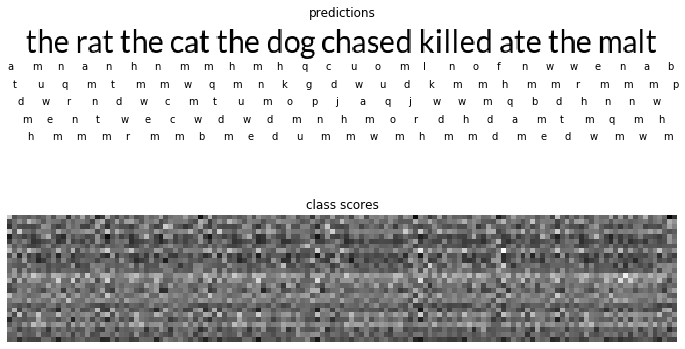

In [81]:
# Visualize the predicted string
plt.figure(1, figsize=(12,8))
lab.plot_predicted_string(im, y) ;

> **Tasks:** inspect the output of the `lab.plot_predicted_string()` function and answer the following:
> 
> 1.  Is the quality of the recognition any good?
> 2.  Does this match your expectation given the recognition rate in your validation set (as reported by `lab.train_model()` during training)?

### Part 4.7: training with jitter

A key issue with the previous CNN is that it is not trained to recognise characters in the context of other characters. Furthermore, characters are perfectly centred in the patch. We can relax these assumptions by making the training data "more realistic". In this part we will train a second network applying *data jittering* by:

1.   Randomly adding a character to the left and to the right of the one recognised and
2.   Randomly shifting the characters by up to $\pm 5$ pixels horizontally and $\pm 2$ pixels vertically.

This is implemented by the `lab.jitter()`  function (note that jittering is applied on the fly as it is so fast). This code shows the effect of the function:

In [ ]:
# Plot images before jitter
plt.figure(1,figsize=(12,12))
plt.title("Without jitter")
lab.imarraysc(imdb['images'][:64],spacing=1)

# Plot images after jitter
plt.figure(2,figsize=(12,12))
plt.title("With jitter")
lab.imarraysc(lab.jitter(imdb['images'][:64]),spacing=1) ;

> **Tasks:**
> 
> 1.  Train a second model, using the jittered data. For this, use the `jitter=lab.jitter` option of `lab.train_model()` to specify a jitter function.
> 2.  Look at the training and validation errors. Is their gap as wide as it was before?
> 3.  Use the new model to recognise the characters in the sentence by repeating the previous part. Does it work better?
> 4.  **Advanced.** What else can you change to make the performance even better?

## Part 5: using pretrained models

A characteristic of deep learning is that it constructs *representations* of the data. These representations tend to have a universal value, or at least to be applicable to an array of problems that transcends the particular task a model was trained for. This is fortunate as training complex models requires weeks of works on one or more GPUs or hundreds of CPUs; these models can then be frozen and reused for a number of additional applications, with no or minimal additional work.

In this part we will see how PyTorch can be used to run pre-trained high-performance CNN models for image classification. These models are trained from 1.2M images in the ImageNet datasets to discriminate 1,000 different object categories.

Several [pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) can be downloaded from the `torchvision` repository. A copy of one such models is provided for convenience in the practical, in the `data/alexnet.pth` file. This is the standard AlexNet model winner of the ImageNet ILSVCR 2012 Challenge.

### Part 5.1:  load a pre-trained model

The first step is to load the model itself. This is done by instantiating AlexNet using `torchvision.models.alexnet` and then loading its parameters using `torch.load`:

In [ ]:
# Show the file
!ls -lh data/alexnet.pth

# Import the model
import torchvision
alexnet = torchvision.models.alexnet(pretrained=False)
alexnet.load_state_dict(torch.load('data/alexnet.pth'))

# Display the model structure
print(alexnet)

> **Tasks:**
> 
> 1.   Look at the output and understand the structure of the model. How many convolutional layers are there?
> 2.   Look at the size of the file `data/alexnet.mat` on disk. This is *just the model*.

### Part 5.2: use the model to classify an image

We can now use the model to classify an image. We start from `peppers.png`:

In [ ]:
from PIL import Image

# Obtain and preprocess an image
im = Image.open('data/peppers.png')

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224),),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

im_normalized = preprocess(im)[None,:]
print(f"The shape of AlexNet input is {list(im_normalized.shape)}")

The code defines a transformation which takes an input image as read by the Python PIL library (Pillow to be more exact) and normalises in a format compatible with the model `alexnet`. This amounts to: resizing the image to a fixed size of $224 \times 224$ pixels, converting the image to `single` format (in the range $[0, 1]$), and then subtracting the per-channel mean and dividing by the per-channel variance.

It is now possible to call the CNN on the normalized input `im_normalized`. This requires switching the model to evaluation mode by calling the `.eval()` method, as follows:

In [ ]:
# Put the model in evaluation mode
alexnet.eval()

# Run the CNN
y = alexnet(im_normalized)

print(f"The shape of AlexNet output is {list(y.shape)}")

The output tensor `y` contains the results of the computation and can be used to perform the classification:

In [ ]:
import json

# Get the best class index and score
best, bestk = y.max(dim=1)

# Get the corresponding class name
with open('data/imnet_classes.json') as f:
    classes = json.load(f)
name = classes[str(bestk.item())][1]

# Plot the results
plt.figure(1, figsize=(8,8))
lab.imsc(im_normalized[0])
plt.title(f"{name} ({bestk.item()}), score {best.item():.3f}") ;

That completes this practical.

## Links and further work

* The code for this practical is written using PyTorch. This is a software library written in Python, C++, and CUDA and is freely available as source code and binary.

## Acknowledgements

* Beta testing by: Karel Lenc and Carlos Arteta.
* Bugfixes/typos by: Sun Yushi.
* Funding from ERC grant "Integrated and Detailed Image Understanding", and the EPSRC Programme Grant "SeeBiByte".

<img style="height:100px" src="data/erc.jpg" alt="erc" />
<img style="height:50px" src="data/epsrc.png" alt="epsrc" />

## History

* Used in the Oxford AIMS CDT, 2018-19 (PyTorch).
* Used in the Oxford AIMS CDT, 2017-18.
* Used in the Oxford AIMS CDT, 2016-17.
* Used in the Oxford AIMS CDT, 2015-16.
* Used in the Oxford AIMS CDT, 2014-15.

<a id='notes'></a>

## Notes

* A two-dimensional *lattice* is a discrete grid embedded in $\mathbb{R}^2$, similar for example to a checkerboard.
* The stacking of a tensor $\bx \in\mathbb{R}^{C\times W\times H}$ is the vector $$ \vv \bx= \begin{bmatrix} x_{000}\\ x_{100} \\ \vdots \\ x_{C-1,0,0} \\ x_{010} \\\vdots \\ x_{C-1,H-1,W-1} \end{bmatrix}.$$